In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.Q_BAI import Q_UGapEc
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva

%matplotlib inline

In [2]:
# environment

environments = [
    {Mixture_AbsGau: [[3, 1, 0,1, 1], [1.2, 4, 0, 1, 1], 
                      #[3, 1, 0,1, 1], [1.2, 4, 0, 1, 1],
                      #[3, 1, 0,1, 1], [1.2, 4, 0, 1, 1],
                      #[3, 1, 0,1, 1], [1.2, 4, 0, 1, 1],
                      #[3, 1, 0,1, 1]
                     ],
     Exp: [[1/3.5]]} # mu1, sigma1, mu2, sigma2, p
    
]

tau = 0.5 # quantile level
est_flag = False # True: estimate the lower bound of hazard rate L; False: use the true L

rewards_env, quantiles, Ls, means, samples = setup_env(environments, tau)

{<class 'codes.Environment.Mixture_AbsGau'>: [[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]], <class 'codes.Environment.Exp'>: [[0.2857142857142857]]}


In [3]:
arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C'
}

for key in quantiles.keys():
    print(key)
    quantiles[key] = list(np.around(np.array(quantiles[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row([str(tau) + '-Quantile'] + quantiles[key]+ [arm_name_dict[np.argmax(quantiles[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    t.add_row(['L']+ Ls[key]+ [arm_name_dict[np.argmax(Ls[key])]])
    print(t)
    print()

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[[0.2857142857142857]]
+--------------+----------------------+---------------------+--------------------+----------+
|     Eva      |          A           |          B          |         C          | Best Arm |
+--------------+----------------------+---------------------+--------------------+----------+
| 0.5-Quantile |         3.0          |         2.82        |        2.4         |    A     |
|     Mean     |         3.0          |         3.33        |        3.48        |    C     |
|      L       | 0.008863696823876015 | 0.19069390773026207 | 0.2857142857142857 |    C     |
+--------------+----------------------+---------------------+--------------------+----------+



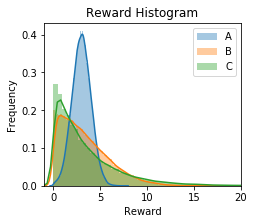

In [4]:
plot_hist(samples)

In [5]:
# run experiments

def run_exper(rewards_env, hyperpara_list, num_exper, budget_or_confi, epsilon, tau, m, policy, summary_stats, est_flags = [est_flag]):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            for est_flag in est_flags:
                name = key + '_' + str(num_exper) + '_' + str(budget_or_confi)
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                subname = policy_name + str(hyperpara)
                print(name + subname)
                p = IntProgress(max = num_exper)
                p.description = 'Running'
                display(p)
                results[name][subname] = simulate(rewards_env[key],summary_stats[key], policy, 
                                                 epsilon, tau, m, budget_or_confi, num_exper, est_flag, hyperpara, None, p)

In [6]:
# setting

results = defaultdict(dict)

num_exper = 1000
confi = 0.02
epsilon = 0.5
m = 1
# hyperpara_list = [[0.05, 1], [0.01, 1], [0.005, 1], [0.001, 1], [0.0005, 1]] # alpha, L estimate threshold
hyperpara_list = [[0.0005, 1]]

In [7]:
run_exper(rewards_env, hyperpara_list, num_exper, confi, epsilon, tau, m, Q_UGapEc, quantiles)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[[0.2857142857142857]]_1000_0.02Q_UGapEc-[0.0005, 1]


IntProgress(value=0, description='Running', max=1000)

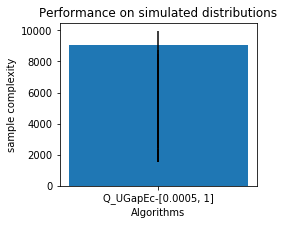

In [8]:
plot_eva(results, 'sc', paper_flag = False)

In [9]:
import pickle

with open('simulation.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)